<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.9.12.5-LSTMB128_dr0_rdr20_batch128_lr001-glove_with_stop_nonlemmatized-1mil-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained GloVe embedding using LSTM with 1mil samples without removing stop words

For this notebook, we will use 500k samples using architecture that was suggested by Wanliang Tan et al in [Sentiment Analysis for Amazon Reviews](http://cs229.stanford.edu/proj2018/report/122.pdf)

In this paper, they were able to achieve test set accuracy of 70%:
* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM hidden units with 0.2 dropout rate
* learning rate of 0.001
* batch size of 128
* 20 epochs
* patience: 4
* total samples: 1m


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
# check what GPU we got
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# check that we are using high RAM runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sun May 17 14:20:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    38W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 128 # total LSTM units
# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.0
RECURRENT_DROPOUT_RATE = 0.2
PATIENCE = 4
BIDIRECTIONAL = False
BALANCE_CLASS_WEIGHTS = True
TRAIN_EMBEDDINGS = False
MODEL_VERSION = 1
ENVIRONMENT = "6.9.12.5-LSTMB128_dr0_rdr20_batch128_lr001-glove_with_stop_nonlemmatized-1mil-prototype.ipynb"
SAMPLES = "1m"


# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100


if BIDIRECTIONAL:
  bidirectional_name = "bi"
else:
  bidirectional_name = ""

if BALANCE_CLASS_WEIGHTS:
  balanced_name = "B"
else:
  balanced_name = ""

MODEL_NAME = f"{bidirectional_name}LSTM{balanced_name}{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, Dropout {DROPOUT_RATE}, Recurrent Dropout {RECURRENT_DROPOUT_RATE}, Batch Size {BATCH_SIZE}, Learning Rate {LEARNING_RATE}"
FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"


REPORT_FILE = f"{MODEL_NAME}_" \
              f"dr{ku.get_decimal_str(DROPOUT_RATE)}_" \
              f"rdr{ku.get_decimal_str(RECURRENT_DROPOUT_RATE)}_" \
              f"batch{BATCH_SIZE}_" \
              f"lr{ku.get_decimal_str(LEARNING_RATE)}-{FEATURE_SET_NAME}-dl_prototype-report.csv"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f"test-{REPORT_FILE}")
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'


start_time = datetime.now()




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]

# Preprocessing

In [5]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=116983
Number of Documents=748261
Train review vectors shape: (748261, 100)  Test review vectors shape: (249421, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [6]:

EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))




Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [7]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 116984
embedding_matrix shape: (116985, 300)
Number of missing words from our vocabulary: 47763


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [9]:
vocab_size = len(t.word_index)+1

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

mw = ku.LSTM1LayerModelWrapper(
                        lstm_dim=LSTM_DIM, # LSTM dim - LSTM1LyerModelWrapper
                          dropout_rate=DROPOUT_RATE, # dropout rate - LSTM1LyerModelWrapper
                          recurrent_dropout_rate=RECURRENT_DROPOUT_RATE, # recurrent dropout rate - LSTM1LyerModelWrapper
                          bidirectional=BIDIRECTIONAL, # bidirectional - LSTM1LyerModelWrapper
                          vocab_size=vocab_size,       # vocab size - EmbeddingModelWrapper
                          max_sequence_length=MAX_SEQUENCE_LENGTH, # max sequence length - EmbeddingModelWrapper
                          embed_size=EMBED_SIZE, # embed size - EmbeddingModelWrapper
                        train_embeddings=TRAIN_EMBEDDINGS, # trainable embedding - EmbeddingModelWrapper
                        model_name=MODEL_NAME, # model name - ModelWrapper
                        architecture=ARCHITECTURE, # architecture - ModelWrapper
                        feature_set_name=FEATURE_SET_NAME, # feature_set_name - ModelWrapper
                        label_column=LABEL_COLUMN, # label_column - ModelWrapper
                        feature_column=FEATURE_COLUMN, # feature_column - ModelWrapper
                        data_file=DATA_FILE, # data file - ModelWrapper
                        sample_size_str = SAMPLES, # sample size string - ModelWrapper
                        tokenizer = t, # tokenizer - ModelWrapper
                        description = DESCRIPTION, #description - ModelWrapper
                        optimizer_name = "Adam", # optimizer name - ModelWrapper
                        learning_rate = LEARNING_RATE, # learning rate - ModelWrapper
                        batch_size = BATCH_SIZE, # batch size = ModelWrapper
                        model_version = MODEL_VERSION, # model version = ModelWrapper
                        save_dir = DRIVE_DIR # model version = ModelWrapper
)



mw.add("environment", ENVIRONMENT)
mw.add("patience", PATIENCE)

network_history = mw.fit(X_train, y_train,
                      epochs = EPOCHS,
                      verbose = 1,
                      validation_split = 0.2,
                      balance_class_weights = BALANCE_CLASS_WEIGHTS,
                      callbacks=[early_stop, reduce_lr])

                      

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          35095500  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 35,315,793
Trainable params: 220,293
Non-trainable params: 35,095,500
_________________________________________________________________
Build model:
None
Epoch 1/20
4677/4677 [==============================] - ETA: 0s - loss: 1.2596 - categorical_accuracy: 0.5396
Epoch 00001: val_loss improved from inf to 1.03043, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
Instructions for

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1868s 399ms/step - loss: 1.2596 - categorical_accuracy: 0.5396 - val_loss: 1.0304 - val_categorical_accuracy: 0.5953 - lr: 0.0010
Epoch 2/20
4677/4677 [==============================] - ETA: 0s - loss: 1.1281 - categorical_accuracy: 0.5963
Epoch 00002: val_loss improved from 1.03043 to 0.93512, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1898s 406ms/step - loss: 1.1281 - categorical_accuracy: 0.5963 - val_loss: 0.9351 - val_categorical_accuracy: 0.6334 - lr: 0.0010
Epoch 3/20
4677/4677 [==============================] - ETA: 0s - loss: 1.0759 - categorical_accuracy: 0.6192
Epoch 00003: val_loss did not improve from 0.93512
4677/4677 [==============================] - 1858s 397ms/step - loss: 1.0759 - categorical_accuracy: 0.6192 - val_loss: 0.9375 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 4/20
4677/4677 [==============================] - ETA: 0s - loss: 1.0427 - categorical_accuracy: 0.6313
Epoch 00004: val_loss did not improve from 0.93512
4677/4677 [==============================] - 1812s 387ms/step - loss: 1.0427 - categorical_accuracy: 0.6313 - val_loss: 0.9592 - val_categorical_accuracy: 0.6046 - lr: 0.0010
Epoch 5/20
4677/4677 [==============================] - ETA: 0s - loss: 1.0178 - categorical_accuracy: 0.6404
Epoch 00005: val_loss improved from 0.93512

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1798s 385ms/step - loss: 1.0178 - categorical_accuracy: 0.6404 - val_loss: 0.8984 - val_categorical_accuracy: 0.6390 - lr: 0.0010
Epoch 6/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9980 - categorical_accuracy: 0.6469
Epoch 00006: val_loss improved from 0.89839 to 0.86548, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1797s 384ms/step - loss: 0.9980 - categorical_accuracy: 0.6469 - val_loss: 0.8655 - val_categorical_accuracy: 0.6560 - lr: 0.0010
Epoch 7/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9827 - categorical_accuracy: 0.6529
Epoch 00007: val_loss did not improve from 0.86548
4677/4677 [==============================] - 1805s 386ms/step - loss: 0.9827 - categorical_accuracy: 0.6529 - val_loss: 0.9157 - val_categorical_accuracy: 0.6219 - lr: 0.0010
Epoch 8/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9695 - categorical_accuracy: 0.6570
Epoch 00008: val_loss improved from 0.86548 to 0.86426, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-samp

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1811s 387ms/step - loss: 0.9695 - categorical_accuracy: 0.6570 - val_loss: 0.8643 - val_categorical_accuracy: 0.6497 - lr: 0.0010
Epoch 9/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9574 - categorical_accuracy: 0.6609
Epoch 00009: val_loss improved from 0.86426 to 0.84466, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1788s 382ms/step - loss: 0.9574 - categorical_accuracy: 0.6609 - val_loss: 0.8447 - val_categorical_accuracy: 0.6584 - lr: 0.0010
Epoch 10/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9477 - categorical_accuracy: 0.6640
Epoch 00010: val_loss improved from 0.84466 to 0.83288, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1799s 385ms/step - loss: 0.9477 - categorical_accuracy: 0.6640 - val_loss: 0.8329 - val_categorical_accuracy: 0.6605 - lr: 0.0010
Epoch 11/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9377 - categorical_accuracy: 0.6683
Epoch 00011: val_loss improved from 0.83288 to 0.81252, saving model to drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/checkpoints/assets


4677/4677 [==============================] - 1797s 384ms/step - loss: 0.9377 - categorical_accuracy: 0.6683 - val_loss: 0.8125 - val_categorical_accuracy: 0.6748 - lr: 0.0010
Epoch 12/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9287 - categorical_accuracy: 0.6700
Epoch 00012: val_loss did not improve from 0.81252
4677/4677 [==============================] - 1811s 387ms/step - loss: 0.9287 - categorical_accuracy: 0.6700 - val_loss: 0.8657 - val_categorical_accuracy: 0.6451 - lr: 0.0010
Epoch 13/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9208 - categorical_accuracy: 0.6716
Epoch 00013: val_loss did not improve from 0.81252
4677/4677 [==============================] - 1786s 382ms/step - loss: 0.9208 - categorical_accuracy: 0.6716 - val_loss: 0.8392 - val_categorical_accuracy: 0.6586 - lr: 0.0010
Epoch 14/20
4677/4677 [==============================] - ETA: 0s - loss: 0.9129 - categorical_accuracy: 0.6743
Epoch 00014: val_loss did not improve fr

In [10]:
scores = mw.evaluate(X_test, y_test)
print("Training Accuracy: %.2f%%" % (mw.train_scores[1]*100))
print("Test Accuracy: %.2f%%" % (mw.test_scores[1]*100))

print(f'Score: {ru.calculate_metric(mw.test_crd)}')


mw.save(append_report=True)

Number of test: 249421
Running model.evaluate on test set...
7795/7795 [==============================] - 276s 35ms/step - loss: 0.8105 - categorical_accuracy: 0.6760
Running model.predict on test set...
Unencode test set predictions...
Generating test set confusion matrix...
Calculating test set ROC AUC...
(249421, 5)
Getting test set classification report...
Running model.evaluate on training set...
23384/23384 [==============================] - 837s 36ms/step - loss: 0.7747 - categorical_accuracy: 0.6904
Running model.predict on training set...
Unencode training set predictions...
Generating training set confusion matrix...
Calculating training set ROC AUC...
(748261, 5)
Getting training set classification report...
Training Accuracy: 69.04%
Test Accuracy: 67.60%
Score: 0.5412968762800212
Saving to report file: drive/My Drive/Springboard/capstone/reports/LSTMB128_dr0_rdr2_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv
Loading to append to: drive/My Drive/Spring

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128-1x128-dr0-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-1m-review_body-v1/1/assets


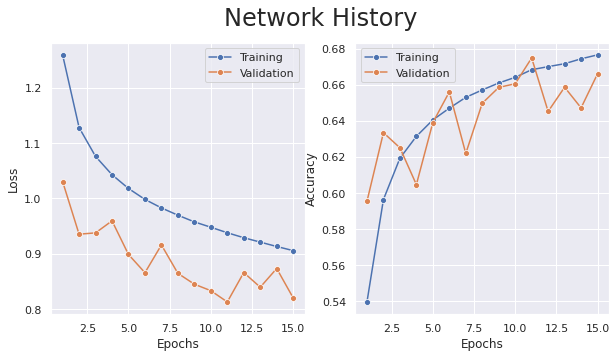


Confusion Matrix
[[ 24434   7636   1924    329    696]
 [  4739   7263   3593    596    409]
 [  1726   4967  10368   3737   1473]
 [   660   1373   6830  18784  13988]
 [  1568   1367   4165  19046 107750]]

Classification Report
              precision    recall  f1-score   support

           1       0.74      0.70      0.72     35019
           2       0.32      0.44      0.37     16600
           3       0.39      0.47      0.42     22271
           4       0.44      0.45      0.45     41635
           5       0.87      0.80      0.83    133896

    accuracy                           0.68    249421
   macro avg       0.55      0.57      0.56    249421
weighted avg       0.70      0.68      0.69    249421



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

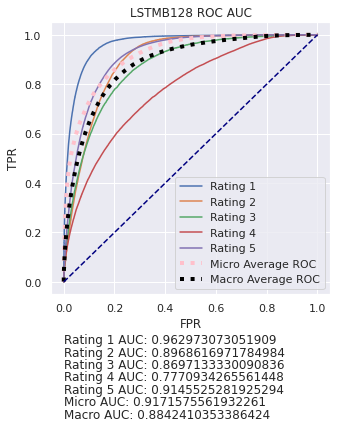

In [11]:

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.test_confusion_matrix)

print("\nClassification Report")
print(mw.test_classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.test_roc_auc, mw.test_fpr, mw.test_tpr)



# Test That Our Models Saved Correctly

In [12]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


7795/7795 [==============================] - 281s 36ms/step - loss: 0.8105 - categorical_accuracy: 0.6760
Accuracy: 67.60%


In [13]:
end_time = datetime.now()
print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Total Duraction {round((end_time - start_time).total_seconds() / 60, 2)} mins")

Start Time: 2020-05-17 14:20:12.106336
End Time: 2020-05-17 22:41:32.458532
Total Duraction 501.34 mins


# Saving to TensorFlow SavedModel format

In [14]:
tf.saved_model.save(mw.model, f"{DRIVE_DIR}/models/LSTMB128_dr0_dr20_batch128_lr01-500k/1/")

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128_dr0_dr20_batch128_lr01-500k/1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/LSTMB128_dr0_dr20_batch128_lr01-500k/1/assets


In [15]:
# !saved_model_cli show --dir 'drive/My Drive/Springboard/capstone/models/LSTMB128_dr0_dr20_batch128_lr01-500k/1/' --all
!saved_model_cli show --dir '{DRIVE_DIR}/models/LSTMB128_dr0_dr20_batch128_lr01-500k/1/' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['embedding_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100)
        name: serving_default_embedding_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0517 22:41:40.423008 140143408793472 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python